## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-10-30 10:12:52--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.39.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.39.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  72.5MB/s    in 4.9s    

2019-10-30 10:12:57 (66.1 MB/s) - ‘/data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [8]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [9]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=18432, out_features=1000, bias=True)
  (fc_2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc_3): Linear(in_features=1000, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.7)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
#data_transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

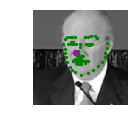

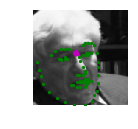

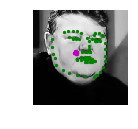

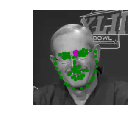

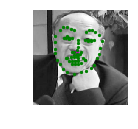

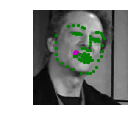

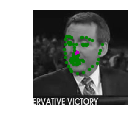

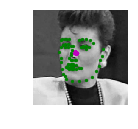

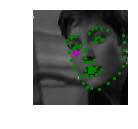

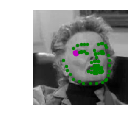

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim
# Mean square error is choosen since it is a linear regression problem 
criterion = nn.MSELoss()
# Based on the article 
# https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.48871133029460906
Epoch: 1, Batch: 20, Avg. Loss: 0.23142516762018203
Epoch: 1, Batch: 30, Avg. Loss: 0.24436382651329042
Epoch: 1, Batch: 40, Avg. Loss: 0.2852860987186432
Epoch: 1, Batch: 50, Avg. Loss: 0.24115316048264504
Epoch: 1, Batch: 60, Avg. Loss: 0.21516648679971695
Epoch: 1, Batch: 70, Avg. Loss: 0.2655288577079773
Epoch: 1, Batch: 80, Avg. Loss: 0.2526722505688667
Epoch: 1, Batch: 90, Avg. Loss: 0.20507341176271437
Epoch: 1, Batch: 100, Avg. Loss: 0.22557522505521774
Epoch: 1, Batch: 110, Avg. Loss: 0.22862261682748794
Epoch: 1, Batch: 120, Avg. Loss: 0.18693191707134246
Epoch: 1, Batch: 130, Avg. Loss: 0.1771826148033142
Epoch: 1, Batch: 140, Avg. Loss: 0.20155226588249206
Epoch: 1, Batch: 150, Avg. Loss: 0.21288403645157813
Epoch: 1, Batch: 160, Avg. Loss: 0.19581480249762534
Epoch: 1, Batch: 170, Avg. Loss: 0.17981189414858817
Epoch: 1, Batch: 180, Avg. Loss: 0.1929774761199951
Epoch: 1, Batch: 190, Avg. Loss: 0.18357252106070518
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.17621692419052123
Epoch: 2, Batch: 20, Avg. Loss: 0.15540680885314942
Epoch: 2, Batch: 30, Avg. Loss: 0.16988524720072745
Epoch: 2, Batch: 40, Avg. Loss: 0.19704216495156288
Epoch: 2, Batch: 50, Avg. Loss: 0.1971396952867508
Epoch: 2, Batch: 60, Avg. Loss: 0.1451401099562645
Epoch: 2, Batch: 70, Avg. Loss: 0.20076503232121468
Epoch: 2, Batch: 80, Avg. Loss: 0.1615617021918297
Epoch: 2, Batch: 90, Avg. Loss: 0.1878209173679352
Epoch: 2, Batch: 100, Avg. Loss: 0.1684051476418972
Epoch: 2, Batch: 110, Avg. Loss: 0.16104634776711463
Epoch: 2, Batch: 120, Avg. Loss: 0.1703883834183216
Epoch: 2, Batch: 130, Avg. Loss: 0.1627257950603962
Epoch: 2, Batch: 140, Avg. Loss: 0.17290125414729118
Epoch: 2, Batch: 150, Avg. Loss: 0.18581650480628015
Epoch: 2, Batch: 160, Avg. Loss: 0.20842226073145867
Epoch: 2, Batch: 170, Avg. Loss: 0.1582294650375843
Epoch: 2, Batch: 180, Avg. Loss: 0.2183612495660782
Epoch: 2, Batch: 190, Avg. Loss: 0.18641482591629027
Epoch: 2, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.135339592397213
Epoch: 3, Batch: 20, Avg. Loss: 0.1592078275978565
Epoch: 3, Batch: 30, Avg. Loss: 0.18730298057198524
Epoch: 3, Batch: 40, Avg. Loss: 0.1934792622923851
Epoch: 3, Batch: 50, Avg. Loss: 0.17120742052793503
Epoch: 3, Batch: 60, Avg. Loss: 0.1695392295718193
Epoch: 3, Batch: 70, Avg. Loss: 0.18554310202598573
Epoch: 3, Batch: 80, Avg. Loss: 0.19346699714660645
Epoch: 3, Batch: 90, Avg. Loss: 0.1421189196407795
Epoch: 3, Batch: 100, Avg. Loss: 0.27049120888113976
Epoch: 3, Batch: 110, Avg. Loss: 0.12780821323394775
Epoch: 3, Batch: 120, Avg. Loss: 0.16098660007119178
Epoch: 3, Batch: 130, Avg. Loss: 0.13015351071953773
Epoch: 3, Batch: 140, Avg. Loss: 0.17774612978100776
Epoch: 3, Batch: 150, Avg. Loss: 0.18068071827292442
Epoch: 3, Batch: 160, Avg. Loss: 0.13210098445415497
Epoch: 3, Batch: 170, Avg. Loss: 0.1521042488515377
Epoch: 3, Batch: 180, Avg. Loss: 0.18113741427659988
Epoch: 3, Batch: 190, Avg. Loss: 0.2766779184341431
Epoch: 3, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.15504729226231576
Epoch: 4, Batch: 20, Avg. Loss: 0.1727961480617523
Epoch: 4, Batch: 30, Avg. Loss: 0.17187557443976403
Epoch: 4, Batch: 40, Avg. Loss: 0.1979996919631958
Epoch: 4, Batch: 50, Avg. Loss: 0.11541019007563591
Epoch: 4, Batch: 60, Avg. Loss: 0.14020361751317978
Epoch: 4, Batch: 70, Avg. Loss: 0.14000460654497146
Epoch: 4, Batch: 80, Avg. Loss: 0.1490035928785801
Epoch: 4, Batch: 90, Avg. Loss: 0.13810210227966307
Epoch: 4, Batch: 100, Avg. Loss: 0.17738667950034143
Epoch: 4, Batch: 110, Avg. Loss: 0.17522442638874053
Epoch: 4, Batch: 120, Avg. Loss: 0.14716666266322137
Epoch: 4, Batch: 130, Avg. Loss: 0.12316241264343261
Epoch: 4, Batch: 140, Avg. Loss: 0.14544085115194322
Epoch: 4, Batch: 150, Avg. Loss: 0.14208196103572845
Epoch: 4, Batch: 160, Avg. Loss: 0.15226042196154593
Epoch: 4, Batch: 170, Avg. Loss: 0.13438042998313904
Epoch: 4, Batch: 180, Avg. Loss: 0.16050556674599648
Epoch: 4, Batch: 190, Avg. Loss: 0.15099919810891152
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.1564173012971878
Epoch: 5, Batch: 20, Avg. Loss: 0.15010941848158837
Epoch: 5, Batch: 30, Avg. Loss: 0.1293754383921623
Epoch: 5, Batch: 40, Avg. Loss: 0.18086538463830948
Epoch: 5, Batch: 50, Avg. Loss: 0.1539372146129608
Epoch: 5, Batch: 60, Avg. Loss: 0.14656437411904336
Epoch: 5, Batch: 70, Avg. Loss: 0.12709644362330436
Epoch: 5, Batch: 80, Avg. Loss: 0.10281376987695694
Epoch: 5, Batch: 90, Avg. Loss: 0.13201506473124028
Epoch: 5, Batch: 100, Avg. Loss: 0.11823685057461261
Epoch: 5, Batch: 110, Avg. Loss: 0.129429941624403
Epoch: 5, Batch: 120, Avg. Loss: 0.16267926320433618
Epoch: 5, Batch: 130, Avg. Loss: 0.09586828537285327
Epoch: 5, Batch: 140, Avg. Loss: 0.11573308929800988
Epoch: 5, Batch: 150, Avg. Loss: 0.09292998239398002
Epoch: 5, Batch: 160, Avg. Loss: 0.10820940248668194
Epoch: 5, Batch: 170, Avg. Loss: 0.09994269646704197
Epoch: 5, Batch: 180, Avg. Loss: 0.1131136454641819
Epoch: 5, Batch: 190, Avg. Loss: 0.11635849475860596
Epoch: 5

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.09374214112758636
Epoch: 6, Batch: 20, Avg. Loss: 0.11468233503401279
Epoch: 6, Batch: 30, Avg. Loss: 0.07861096747219562
Epoch: 6, Batch: 40, Avg. Loss: 0.10878236331045628
Epoch: 6, Batch: 50, Avg. Loss: 0.09757726714015007
Epoch: 6, Batch: 60, Avg. Loss: 0.08760335333645344
Epoch: 6, Batch: 70, Avg. Loss: 0.1097190611064434
Epoch: 6, Batch: 80, Avg. Loss: 0.07238558419048786
Epoch: 6, Batch: 90, Avg. Loss: 0.11319947838783265
Epoch: 6, Batch: 100, Avg. Loss: 0.0920963428914547
Epoch: 6, Batch: 110, Avg. Loss: 0.11596124805510044
Epoch: 6, Batch: 120, Avg. Loss: 0.10967596247792244
Epoch: 6, Batch: 130, Avg. Loss: 0.07706352435052395
Epoch: 6, Batch: 140, Avg. Loss: 0.07897311300039292
Epoch: 6, Batch: 150, Avg. Loss: 0.10123197324573993
Epoch: 6, Batch: 160, Avg. Loss: 0.1075409423559904
Epoch: 6, Batch: 170, Avg. Loss: 0.12225482128560543
Epoch: 6, Batch: 180, Avg. Loss: 0.12100512124598026
Epoch: 6, Batch: 190, Avg. Loss: 0.15295904576778413
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.1025966614484787
Epoch: 7, Batch: 20, Avg. Loss: 0.08866489455103874
Epoch: 7, Batch: 30, Avg. Loss: 0.10342903658747674
Epoch: 7, Batch: 40, Avg. Loss: 0.06875915974378585
Epoch: 7, Batch: 50, Avg. Loss: 0.10529056712985038
Epoch: 7, Batch: 60, Avg. Loss: 0.09398354329168797
Epoch: 7, Batch: 70, Avg. Loss: 0.06592304483056069
Epoch: 7, Batch: 80, Avg. Loss: 0.0716173592954874
Epoch: 7, Batch: 90, Avg. Loss: 0.09696727208793163
Epoch: 7, Batch: 100, Avg. Loss: 0.06792259439826012
Epoch: 7, Batch: 110, Avg. Loss: 0.11512937247753144
Epoch: 7, Batch: 120, Avg. Loss: 0.1148820411413908
Epoch: 7, Batch: 130, Avg. Loss: 0.08101659193634987
Epoch: 7, Batch: 140, Avg. Loss: 0.12211253456771373
Epoch: 7, Batch: 150, Avg. Loss: 0.10171811953186989
Epoch: 7, Batch: 160, Avg. Loss: 0.09578646011650563
Epoch: 7, Batch: 170, Avg. Loss: 0.19531179666519166
Epoch: 7, Batch: 180, Avg. Loss: 0.08222553580999374
Epoch: 7, Batch: 190, Avg. Loss: 0.06907276026904582
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.054031495749950406
Epoch: 8, Batch: 20, Avg. Loss: 0.08006722964346409
Epoch: 8, Batch: 30, Avg. Loss: 0.11131491027772426
Epoch: 8, Batch: 40, Avg. Loss: 0.07822277694940567
Epoch: 8, Batch: 50, Avg. Loss: 0.09728850945830345
Epoch: 8, Batch: 60, Avg. Loss: 0.07685342133045196
Epoch: 8, Batch: 70, Avg. Loss: 0.068492023460567
Epoch: 8, Batch: 80, Avg. Loss: 0.06807912439107895
Epoch: 8, Batch: 90, Avg. Loss: 0.08159213848412036
Epoch: 8, Batch: 100, Avg. Loss: 0.0588868010789156
Epoch: 8, Batch: 110, Avg. Loss: 0.09777929000556469
Epoch: 8, Batch: 120, Avg. Loss: 0.07395539171993733
Epoch: 8, Batch: 130, Avg. Loss: 0.0704579245299101
Epoch: 8, Batch: 140, Avg. Loss: 0.1360297404229641
Epoch: 8, Batch: 150, Avg. Loss: 0.07592095322906971
Epoch: 8, Batch: 160, Avg. Loss: 0.0796983476728201
Epoch: 8, Batch: 170, Avg. Loss: 0.08579505123198032
Epoch: 8, Batch: 180, Avg. Loss: 0.08054007366299629
Epoch: 8, Batch: 190, Avg. Loss: 0.06428067795932293
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.07181842029094695
Epoch: 9, Batch: 20, Avg. Loss: 0.0727228071540594
Epoch: 9, Batch: 30, Avg. Loss: 0.06428924649953842
Epoch: 9, Batch: 40, Avg. Loss: 0.07018068954348564
Epoch: 9, Batch: 50, Avg. Loss: 0.05668708123266697
Epoch: 9, Batch: 60, Avg. Loss: 0.1127255406230688
Epoch: 9, Batch: 70, Avg. Loss: 0.06233560889959335
Epoch: 9, Batch: 80, Avg. Loss: 0.10660519041121005
Epoch: 9, Batch: 90, Avg. Loss: 0.07078579887747764
Epoch: 9, Batch: 100, Avg. Loss: 0.07291986942291259
Epoch: 9, Batch: 110, Avg. Loss: 0.06297756731510162
Epoch: 9, Batch: 120, Avg. Loss: 0.0720414150506258
Epoch: 9, Batch: 130, Avg. Loss: 0.07957563064992428
Epoch: 9, Batch: 140, Avg. Loss: 0.07806301470845937
Epoch: 9, Batch: 150, Avg. Loss: 0.08519302923232316
Epoch: 9, Batch: 160, Avg. Loss: 0.06894550547003746
Epoch: 9, Batch: 170, Avg. Loss: 0.07958926819264889
Epoch: 9, Batch: 180, Avg. Loss: 0.07996543943881988
Epoch: 9, Batch: 190, Avg. Loss: 0.1268815603107214
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.08057672642171383
Epoch: 10, Batch: 20, Avg. Loss: 0.10894500724971294
Epoch: 10, Batch: 30, Avg. Loss: 0.10792283155024052
Epoch: 10, Batch: 40, Avg. Loss: 0.05500427111983299
Epoch: 10, Batch: 50, Avg. Loss: 0.07551775127649307
Epoch: 10, Batch: 60, Avg. Loss: 0.07718877792358399
Epoch: 10, Batch: 70, Avg. Loss: 0.06805398389697075
Epoch: 10, Batch: 80, Avg. Loss: 0.08702587932348252
Epoch: 10, Batch: 90, Avg. Loss: 0.07493260651826858
Epoch: 10, Batch: 100, Avg. Loss: 0.053789520263671876
Epoch: 10, Batch: 110, Avg. Loss: 0.14875527173280717
Epoch: 10, Batch: 120, Avg. Loss: 0.07799785695970059
Epoch: 10, Batch: 130, Avg. Loss: 0.055875847861170766
Epoch: 10, Batch: 140, Avg. Loss: 0.07032085657119751
Epoch: 10, Batch: 150, Avg. Loss: 0.07506796829402447
Epoch: 10, Batch: 160, Avg. Loss: 0.06556955203413964
Epoch: 10, Batch: 170, Avg. Loss: 0.057895902544260025
Epoch: 10, Batch: 180, Avg. Loss: 0.14634257778525353
Epoch: 10, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.05969663932919502
Epoch: 11, Batch: 20, Avg. Loss: 0.05867835115641355
Epoch: 11, Batch: 30, Avg. Loss: 0.08795878924429416
Epoch: 11, Batch: 40, Avg. Loss: 0.06819832101464271
Epoch: 11, Batch: 50, Avg. Loss: 0.21503693275153637
Epoch: 11, Batch: 60, Avg. Loss: 0.07581855244934559
Epoch: 11, Batch: 70, Avg. Loss: 0.11196060106158257
Epoch: 11, Batch: 80, Avg. Loss: 0.07062227316200734
Epoch: 11, Batch: 90, Avg. Loss: 0.07173968777060509
Epoch: 11, Batch: 100, Avg. Loss: 0.06352198012173176
Epoch: 11, Batch: 110, Avg. Loss: 0.08288274332880974
Epoch: 11, Batch: 120, Avg. Loss: 0.06280657537281513
Epoch: 11, Batch: 130, Avg. Loss: 0.06148097701370716
Epoch: 11, Batch: 140, Avg. Loss: 0.07344993799924851
Epoch: 11, Batch: 150, Avg. Loss: 0.10882107242941856
Epoch: 11, Batch: 160, Avg. Loss: 0.06897717267274857
Epoch: 11, Batch: 170, Avg. Loss: 0.06618587709963322
Epoch: 11, Batch: 180, Avg. Loss: 0.06445082388818264
Epoch: 11, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.06703493930399418
Epoch: 12, Batch: 20, Avg. Loss: 0.060498273372650145
Epoch: 12, Batch: 30, Avg. Loss: 0.055572540313005445
Epoch: 12, Batch: 40, Avg. Loss: 0.06077173762023449
Epoch: 12, Batch: 50, Avg. Loss: 0.08523854166269303
Epoch: 12, Batch: 60, Avg. Loss: 0.0746016651391983
Epoch: 12, Batch: 70, Avg. Loss: 0.058253598399460316
Epoch: 12, Batch: 80, Avg. Loss: 0.09011818021535874
Epoch: 12, Batch: 90, Avg. Loss: 0.0770933236926794
Epoch: 12, Batch: 100, Avg. Loss: 0.06555225551128388
Epoch: 12, Batch: 110, Avg. Loss: 0.062254676781594756
Epoch: 12, Batch: 120, Avg. Loss: 0.06709971018135548
Epoch: 12, Batch: 130, Avg. Loss: 0.06927661299705505
Epoch: 12, Batch: 140, Avg. Loss: 0.09553731977939606
Epoch: 12, Batch: 150, Avg. Loss: 0.06667454168200493
Epoch: 12, Batch: 160, Avg. Loss: 0.05482444316148758
Epoch: 12, Batch: 170, Avg. Loss: 0.06498872321099043
Epoch: 12, Batch: 180, Avg. Loss: 0.058884821459650995
Epoch: 12, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.06924892440438271
Epoch: 13, Batch: 20, Avg. Loss: 0.06668678745627403
Epoch: 13, Batch: 30, Avg. Loss: 0.05539686288684607
Epoch: 13, Batch: 40, Avg. Loss: 0.06039576735347509
Epoch: 13, Batch: 50, Avg. Loss: 0.1357562907040119
Epoch: 13, Batch: 60, Avg. Loss: 0.07514437213540077
Epoch: 13, Batch: 70, Avg. Loss: 0.07042777948081494
Epoch: 13, Batch: 80, Avg. Loss: 0.06266194880008698
Epoch: 13, Batch: 90, Avg. Loss: 0.11604389324784278
Epoch: 13, Batch: 100, Avg. Loss: 0.05748653933405876
Epoch: 13, Batch: 110, Avg. Loss: 0.057102035358548166
Epoch: 13, Batch: 120, Avg. Loss: 0.10559551939368247
Epoch: 13, Batch: 130, Avg. Loss: 0.05608673244714737
Epoch: 13, Batch: 140, Avg. Loss: 0.12614333909004927
Epoch: 13, Batch: 150, Avg. Loss: 0.07152063362300395
Epoch: 13, Batch: 160, Avg. Loss: 0.049686677381396295
Epoch: 13, Batch: 170, Avg. Loss: 0.05443335361778736
Epoch: 13, Batch: 180, Avg. Loss: 0.07368864826858043
Epoch: 13, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.05803659148514271
Epoch: 14, Batch: 20, Avg. Loss: 0.06401657573878765
Epoch: 14, Batch: 30, Avg. Loss: 0.06227742470800877
Epoch: 14, Batch: 40, Avg. Loss: 0.06727423369884492
Epoch: 14, Batch: 50, Avg. Loss: 0.04983619563281536
Epoch: 14, Batch: 60, Avg. Loss: 0.07068954519927502
Epoch: 14, Batch: 70, Avg. Loss: 0.05761426948010921
Epoch: 14, Batch: 80, Avg. Loss: 0.07221311405301094
Epoch: 14, Batch: 90, Avg. Loss: 0.053808624669909474
Epoch: 14, Batch: 100, Avg. Loss: 0.09687534384429455
Epoch: 14, Batch: 110, Avg. Loss: 0.06239529401063919
Epoch: 14, Batch: 120, Avg. Loss: 0.08218411467969418
Epoch: 14, Batch: 130, Avg. Loss: 0.05185278933495283
Epoch: 14, Batch: 140, Avg. Loss: 0.0597932156175375
Epoch: 14, Batch: 150, Avg. Loss: 0.0454286627471447
Epoch: 14, Batch: 160, Avg. Loss: 0.05780579075217247
Epoch: 14, Batch: 170, Avg. Loss: 0.06796272359788418
Epoch: 14, Batch: 180, Avg. Loss: 0.06443053930997848
Epoch: 14, Batch: 190, Avg. Loss: 0.05

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.05546021200716496
Epoch: 15, Batch: 20, Avg. Loss: 0.06610162369906902
Epoch: 15, Batch: 30, Avg. Loss: 0.04329326190054417
Epoch: 15, Batch: 40, Avg. Loss: 0.05274445805698633
Epoch: 15, Batch: 50, Avg. Loss: 0.05007942058146
Epoch: 15, Batch: 60, Avg. Loss: 0.06583466418087483
Epoch: 15, Batch: 70, Avg. Loss: 0.056969859451055524
Epoch: 15, Batch: 80, Avg. Loss: 0.0731970950961113
Epoch: 15, Batch: 90, Avg. Loss: 0.07644872292876244
Epoch: 15, Batch: 100, Avg. Loss: 0.0505239125341177
Epoch: 15, Batch: 110, Avg. Loss: 0.08716788738965989
Epoch: 15, Batch: 120, Avg. Loss: 0.06174493245780468
Epoch: 15, Batch: 130, Avg. Loss: 0.07126193381845951
Epoch: 15, Batch: 140, Avg. Loss: 0.05918730050325394
Epoch: 15, Batch: 150, Avg. Loss: 0.05240840539336204
Epoch: 15, Batch: 160, Avg. Loss: 0.05871475711464882
Epoch: 15, Batch: 170, Avg. Loss: 0.04548630472272634
Epoch: 15, Batch: 180, Avg. Loss: 0.06790666971355677
Epoch: 15, Batch: 190, Avg. Loss: 0.04217

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.06390919592231512
Epoch: 16, Batch: 20, Avg. Loss: 0.06213024649769068
Epoch: 16, Batch: 30, Avg. Loss: 0.07309269420802593
Epoch: 16, Batch: 40, Avg. Loss: 0.06658162586390973
Epoch: 16, Batch: 50, Avg. Loss: 0.0608957476913929
Epoch: 16, Batch: 60, Avg. Loss: 0.06148302685469389
Epoch: 16, Batch: 70, Avg. Loss: 0.056898492947220804
Epoch: 16, Batch: 80, Avg. Loss: 0.07223411407321692
Epoch: 16, Batch: 90, Avg. Loss: 0.05165678523480892
Epoch: 16, Batch: 100, Avg. Loss: 0.047801222279667856
Epoch: 16, Batch: 110, Avg. Loss: 0.04760243054479361
Epoch: 16, Batch: 120, Avg. Loss: 0.043227026239037514
Epoch: 16, Batch: 130, Avg. Loss: 0.05835076086223125
Epoch: 16, Batch: 140, Avg. Loss: 0.06151947509497404
Epoch: 16, Batch: 150, Avg. Loss: 0.05711238272488117
Epoch: 16, Batch: 160, Avg. Loss: 0.11869239620864391
Epoch: 16, Batch: 170, Avg. Loss: 0.04537193179130554
Epoch: 16, Batch: 180, Avg. Loss: 0.04431234672665596
Epoch: 16, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.06051761638373136
Epoch: 17, Batch: 20, Avg. Loss: 0.04725505840033293
Epoch: 17, Batch: 30, Avg. Loss: 0.17771059051156043
Epoch: 17, Batch: 40, Avg. Loss: 0.09662352465093135
Epoch: 17, Batch: 50, Avg. Loss: 0.08937178254127502
Epoch: 17, Batch: 60, Avg. Loss: 0.06291667856276036
Epoch: 17, Batch: 70, Avg. Loss: 0.08296284712851047
Epoch: 17, Batch: 80, Avg. Loss: 0.05867366436868906
Epoch: 17, Batch: 90, Avg. Loss: 0.10036870799958705
Epoch: 17, Batch: 100, Avg. Loss: 0.07010619100183249
Epoch: 17, Batch: 110, Avg. Loss: 0.05825979299843311
Epoch: 17, Batch: 120, Avg. Loss: 0.07880820669233798
Epoch: 17, Batch: 130, Avg. Loss: 0.062437120079994204
Epoch: 17, Batch: 140, Avg. Loss: 0.050883392058312896
Epoch: 17, Batch: 150, Avg. Loss: 0.06824845150113105
Epoch: 17, Batch: 160, Avg. Loss: 0.06257680170238018
Epoch: 17, Batch: 170, Avg. Loss: 0.05754604116082192
Epoch: 17, Batch: 180, Avg. Loss: 0.056842201575636866
Epoch: 17, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.06982205044478178
Epoch: 18, Batch: 20, Avg. Loss: 0.04893848374485969
Epoch: 18, Batch: 30, Avg. Loss: 0.058446579799056056
Epoch: 18, Batch: 40, Avg. Loss: 0.09853514209389687
Epoch: 18, Batch: 50, Avg. Loss: 0.06147045530378818
Epoch: 18, Batch: 60, Avg. Loss: 0.09506139233708381
Epoch: 18, Batch: 70, Avg. Loss: 0.0752425104379654
Epoch: 18, Batch: 80, Avg. Loss: 0.049937570467591286
Epoch: 18, Batch: 90, Avg. Loss: 0.05297516509890556
Epoch: 18, Batch: 100, Avg. Loss: 0.05096499398350716
Epoch: 18, Batch: 110, Avg. Loss: 0.05194728262722492
Epoch: 18, Batch: 120, Avg. Loss: 0.053396251238882544
Epoch: 18, Batch: 130, Avg. Loss: 0.05177312139421701
Epoch: 18, Batch: 140, Avg. Loss: 0.05984847117215395
Epoch: 18, Batch: 150, Avg. Loss: 0.04143496640026569
Epoch: 18, Batch: 160, Avg. Loss: 0.05552959144115448
Epoch: 18, Batch: 170, Avg. Loss: 0.09083356261253357
Epoch: 18, Batch: 180, Avg. Loss: 0.07947392649948597
Epoch: 18, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.08555984050035477
Epoch: 19, Batch: 20, Avg. Loss: 0.05783763714134693
Epoch: 19, Batch: 30, Avg. Loss: 0.08767170552164316
Epoch: 19, Batch: 40, Avg. Loss: 0.07318508327007293
Epoch: 19, Batch: 50, Avg. Loss: 0.057067949883639814
Epoch: 19, Batch: 60, Avg. Loss: 0.12519182600080966
Epoch: 19, Batch: 70, Avg. Loss: 0.05156082343310118
Epoch: 19, Batch: 80, Avg. Loss: 0.07492787949740887
Epoch: 19, Batch: 90, Avg. Loss: 0.048605598695576194
Epoch: 19, Batch: 100, Avg. Loss: 0.07026796042919159
Epoch: 19, Batch: 110, Avg. Loss: 0.0717238001525402
Epoch: 19, Batch: 120, Avg. Loss: 0.05328300818800926
Epoch: 19, Batch: 130, Avg. Loss: 0.07422723174095154
Epoch: 19, Batch: 140, Avg. Loss: 0.11778322439640761
Epoch: 19, Batch: 150, Avg. Loss: 0.07826487347483635
Epoch: 19, Batch: 160, Avg. Loss: 0.058912507817149164
Epoch: 19, Batch: 170, Avg. Loss: 0.08707695677876473
Epoch: 19, Batch: 180, Avg. Loss: 0.07013449259102345
Epoch: 19, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.05791499484330416
Epoch: 20, Batch: 20, Avg. Loss: 0.10880994405597448
Epoch: 20, Batch: 30, Avg. Loss: 0.07920140977948904
Epoch: 20, Batch: 40, Avg. Loss: 0.06571902930736542
Epoch: 20, Batch: 50, Avg. Loss: 0.046488890796899794
Epoch: 20, Batch: 60, Avg. Loss: 0.05329424533993006
Epoch: 20, Batch: 70, Avg. Loss: 0.07111167926341296
Epoch: 20, Batch: 80, Avg. Loss: 0.05575889945030212
Epoch: 20, Batch: 90, Avg. Loss: 0.05709217377007007
Epoch: 20, Batch: 100, Avg. Loss: 0.08067343197762966
Epoch: 20, Batch: 110, Avg. Loss: 0.04629194904118776
Epoch: 20, Batch: 120, Avg. Loss: 0.057561755552887915
Epoch: 20, Batch: 130, Avg. Loss: 0.05468211378902197
Epoch: 20, Batch: 140, Avg. Loss: 0.06405356880277395
Epoch: 20, Batch: 150, Avg. Loss: 0.03966498151421547
Epoch: 20, Batch: 160, Avg. Loss: 0.05763213448226452
Epoch: 20, Batch: 170, Avg. Loss: 0.09089721478521824
Epoch: 20, Batch: 180, Avg. Loss: 0.047016026265919206
Epoch: 20, Batch: 190, Avg. Loss: 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


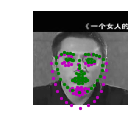

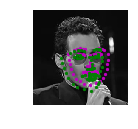

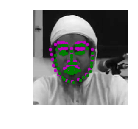

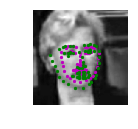

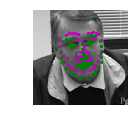

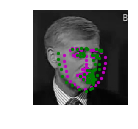

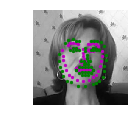

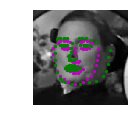

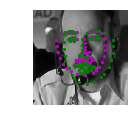

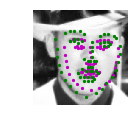

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [6]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_tom6.pt'
# This is the best model after a lot of iterations
# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


I have chosen Mean Square Error first because it is a linear regression problem than a classification problem. We already have the observation value so the MSE is the most ideal one for finding out the distance error between true and predicted key point values.

For the optimization part I have chosen Adaptive moment Estimation -ADAM , it will improve the performance of gradient descent by taking care of the momentum of the loss function. The momentum of the loss function will avoid convergence at local minimum. Also ADAM will ensure that there is a separate learning rate for different parameter. Whichever parameter gets less update will be learned faster. Both this combined effects makes ADAM a good choice for the optimizer


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

Initially I started with a very shallow architecture, with just 2 layers. Then I found that the error rate is not decreasing. When I added two more layers it was giving better results. 
The reason for choosing the kernel size as odd number was because of the symmetry of it. In all the cnn I have choosen kernel size of 3
Number of layers also was chosen in such a way that all will be in power of 2, ie 32,64,128 . I believed it is more natural kind of computation and also I have seen in lot of good network models number of layers are taken as power of 2. 
Fully connected network neuron number -1000 was chosen based on a rule of thumb. It should be between 18432(last fully connected layer total activations) and 136 (68*2).
When I first designed the network I made a mistake of adding max pool after activation, when I flipped those two lot of computation time was saved. 
In order to avoid the overfitting of the data I have strategically increased the dropout rates in each layer.
This came from an intuition that chance of overfitting is more in the final layers compared to the initial layers because they are closer towards the final output.


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

I was doing the assignments from the virtual Jupiter work book (not from machine). Batch size of 10 was the maximum that can avoid, because of the higher memory the training was crashing for a batch size greater than 10. 

Epoch 20 was also an obvious choice. I was not seeing much decrease in the loss function after epoch 20 . So I decided  to go for it.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

(32, 1, 3, 3)
[[-0.24074221 -0.31548223 -0.23906204]
 [ 0.11925313 -0.06394169  0.27939758]
 [ 0.04399398 -0.06005189  0.00909317]]
(3, 3)


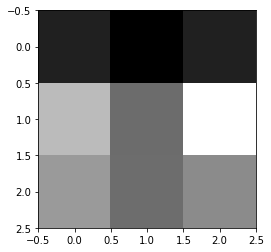

In [12]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()
print (w.shape)

# In the first convolutional layer there are total 32 (3,3) filters we are studying the 27th filter
filter_index = 31

print(w[filter_index][0])
print(w[filter_index][0].shape)

# Displaying 128th filter of 3rd layer 
# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


Text(0.5,1,'Filtered ')

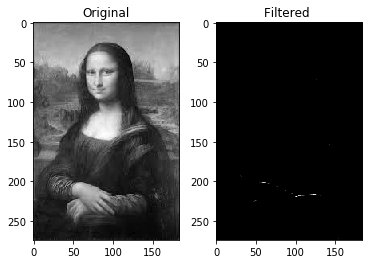

In [13]:

import cv2
import numpy as np
# Reading the gray image 
image = cv2.imread('images/mona_lisa.jpg', 0)
# desired depth of the destination image is given as -1,  if it is negative, it will be the same as src.depth()
image_out = cv2.filter2D(image, -1,  w[filter_index][0])
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(image,  cmap = 'gray')
ax.set_title("Original")
ax = fig.add_subplot(122)
ax.imshow(image_out,  cmap = 'gray')
ax.set_title("Filtered ")



### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


This filter is more close to a high pass filter. From the kernel it is clear that upper horizontal rows are dark and lower two rows are bright. It is specifically looking for pattern like that. Where the upper row is more darker and lower row is brighter. In the filtered output we can see that there are lot of activations in the boundaries of the hand. Here the upper portion of hand is dark cloth and the transition is from dark to bright in horizontally top to down direction. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!